In [1]:
from geogapfiller.gapfiller import median_filler

import pandas as pd

from importlib import reload

## 1. Apply gap-filling methods to reconstruct geospatial data
This code applies four different gaps filling methods to reconstruct geospatial data. In this example, we are using images derived from Harmonized Landsat and Sentinel 2 -  [HLS](https://www.earthdata.nasa.gov/esds/harmonized-landsat-sentinel-2). The methods are: Polynomial, Median, Harmonic, and LightGBM. The use of gap-filing methods is essential to reconstruct data because due to the presence of clouds, shadows, and other atmospheric conditions, can affect the quality of the images. This code can be used to fill gaps in any geospatial data; the only requirement is to have a stack of raster images. The models are adjusted using data within a window of 15 days from the previous and subsequent dates of the current target pixel. For the edge pixels, the first pixels were filled using the subsequent 15 days of available data, and the last pixels were filled using the previous 15 days of valid data.

## 1.1. Median gap-filling approach
The median is preferred over other statistical measures because it is less sensitive to outliers (e.g., mean), which can occur due to atmospheric disturbances or sensor errors. This is a simpler approach that considers the median value among other cloud-free pixels in the time series. However, the method does not take into account the overall trend and seasonality of the time series.

In [ ]:
# Define the path to locate the images
inputdir = r'C:\hlsgapfiller\data'
# Define the path to save the filled images
outputdir = r'C:\crop_phenology\filled_images\goodwater\2023'


Indices of matching dates:
[51, 95, 138]


C:\anaconda\envs\hls\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Total images in evi_img_original: 160
Total images in stack: 160
Indices of matching dates:
[51, 95, 138]


C:\anaconda\envs\hls\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Total images in evi_img_original: 160
Total images in stack: 160
Indices of matching dates:
[51, 95, 138]


C:\anaconda\envs\hls\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Total images in evi_img_original: 160
Total images in stack: 160
Indices of matching dates:
[51, 95, 138]


C:\anaconda\envs\hls\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Total images in evi_img_original: 160
Total images in stack: 160
Indices of matching dates:
[51, 95, 138]


C:\anaconda\envs\hls\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Total images in evi_img_original: 160
Total images in stack: 160


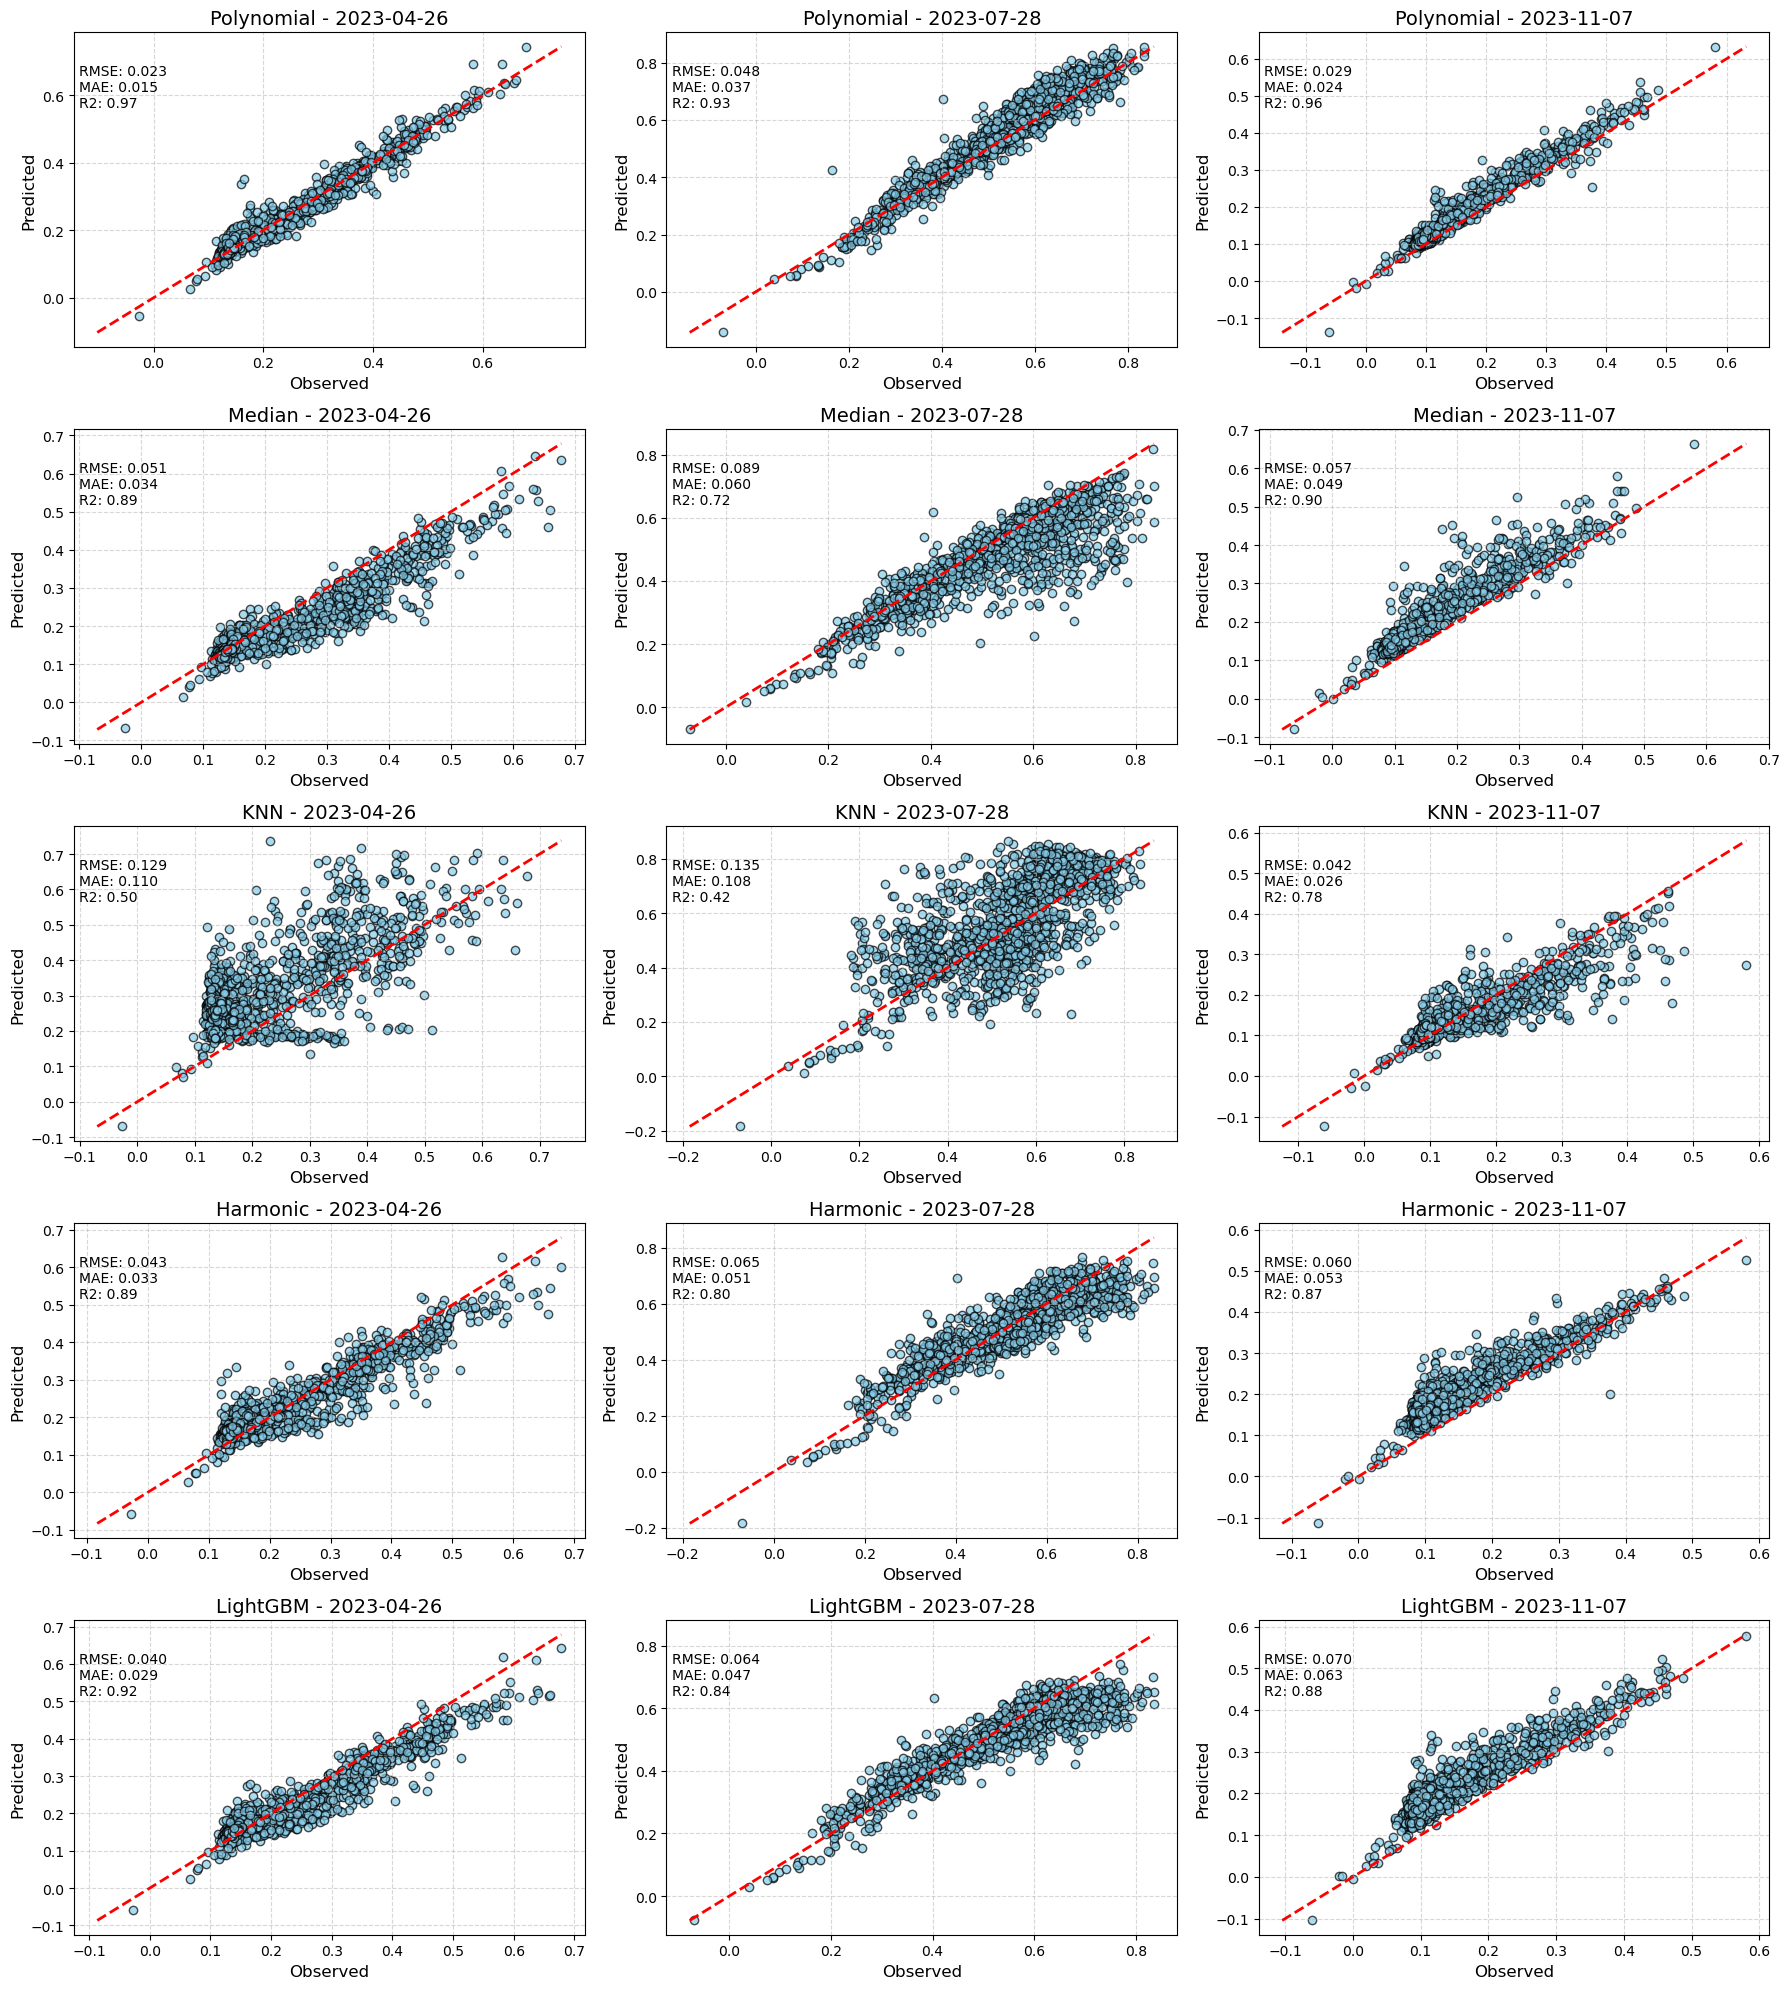

In [115]:
# List of filling gaps techniques
methods = ["Polynomial", "Median", "Harmonic", "LightGBM"]
# Base directory
base_dir = r'C:\crop_phenology'
# Tile id
#tile = f'T{tile_id}'
# Create a grid points to extract the predicted and observed values
# Define grid configuration
grid_distance = 200  # meters
# Distance from a border
offset = 100  # meters
year = '2023'

# List of dates
img_dates = ['2023-04-26']


# Create a list of functions
technique_funcs = [polynomial_filler._poly_filling, median_filler._median_filling,
                   knn_filler._knn_filling, harmonic_filler._harmonic_filling,
                   lightgbm_filler._lightgbm_filling]

# Fill the gaps using the techniques
techniques_filled_data = {}
for func, func_name in zip(technique_funcs, methods):
    evi_obs_values, evi_technique_values = techn_validator.valid_filling_techn(base_dir, img_dates, func, station_name, year, grid_distance, offset)
    techniques_filled_data[func_name] = evi_technique_values

# Plot the techniques metrics
techn_validator.plot_techniques_val(
    img_dates, evi_obs_values, techniques_filled_data['Polynomial'], techniques_filled_data['Median'],
    techniques_filled_data['Harmonic'], techniques_filled_data['LightGBM'], methods, base_dir, station_name
)

## 4. Predict EVI images
This code will predict the EVI images using the best filling gaps method. When changing the predicted interval, the images will be predicted according to this interval.

In [8]:
# Base directory
# Define the base directory
base_dir = r'C:\crop_phenology'
#station_name = 'uiefmaize'
# Predicted interval change it according to the desired interval of image prediction
predicted_interval = 1
years = ['2023']
for year in years:
    # Call the function to predict the EVI images
    img_predictor.predicted_img(base_dir, station_name, predicted_interval, year)


C:\crop_phenology\data_processed\arscolesnorth2\2023\spectral_index\evi\20230101_S30_T15TVH_evi.tif
C:\crop_phenology\data_processed\arscolesnorth2\2023\spectral_index\evi\20230106_S30_T15TVH_evi.tif
C:\crop_phenology\data_processed\arscolesnorth2\2023\spectral_index\evi\20230107_L30_T15TVH_evi.tif
C:\crop_phenology\data_processed\arscolesnorth2\2023\spectral_index\evi\20230108_L30_T15TVH_evi.tif
C:\crop_phenology\data_processed\arscolesnorth2\2023\spectral_index\evi\20230109_S30_T15TVH_evi.tif
C:\crop_phenology\data_processed\arscolesnorth2\2023\spectral_index\evi\20230111_S30_T15TVH_evi.tif
C:\crop_phenology\data_processed\arscolesnorth2\2023\spectral_index\evi\20230115_L30_T15TVH_evi.tif
C:\crop_phenology\data_processed\arscolesnorth2\2023\spectral_index\evi\20230116_S30_T15TVH_evi.tif
C:\crop_phenology\data_processed\arscolesnorth2\2023\spectral_index\evi\20230121_S30_T15TVH_evi.tif
C:\crop_phenology\data_processed\arscolesnorth2\2023\spectral_index\evi\20230123_L30_T15TVH_evi.tif


C:\crop_phenology\src\cropphenology\predicted_img\img_predictor.py:60: RuntimeWarning: Mean of empty slice
  combined_values = np.nanmean([existing_values, new_values], axis=0)


20230101
20230102
20230103
20230104
20230105
20230106
20230107
20230108
20230109
20230110
20230111
20230112
20230113
20230114
20230115
20230116
20230117
20230118
20230119
20230120
20230121
20230122
20230123
20230124
20230125
20230126
20230127
20230128
20230129
20230130
20230131
20230201
20230202
20230203
20230204
20230205
20230206
20230207
20230208
20230209
20230210
20230211
20230212
20230213
20230214
20230215
20230216
20230217
20230218
20230219
20230220
20230221
20230222
20230223
20230224
20230225
20230226
20230227
20230228
20230301
20230302
20230303
20230304
20230305
20230306
20230307
20230308
20230309
20230310
20230311
20230312
20230313
20230314
20230315
20230316
20230317
20230318
20230319
20230320
20230321
20230322
20230323
20230324
20230325
20230326
20230327
20230328
20230329
20230330
20230331
20230401
20230402
20230403
20230404
20230405
20230406
20230407
20230408
20230409
20230410
20230411
20230412
20230413
20230414
20230415
20230416
20230417
20230418
20230419
20230420
20230421
2

## 5. Apply the Savitzky-Golay filter to the predicted EVI images
This code will apply the Savitzky-Golay filter to the predicted EVI images. Adjust the window length and polynomial order according to the desired filter.

In [3]:
base_dir = r'C:\crop_phenology'

# Define the window length and polynomial order
window_length = 70
poly_order = 2
station_name = 'goodwaterbau2'
# Call the functions to apply the Savitzky-Golay filter
savitzkygolay_filter.apply_sg_filter(base_dir, station_name, window_length, poly_order)


## 6. Plot the HLS Mean EVI in related to the Phenocam timeseries
This code will receive the field boundary where the phenocam is installed and plot the HLS Mean EVI in related to the Phenocam timeseries.


C:\anaconda\envs\hls\lib\site-packages\shapely\geometry\polygon.py:260: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.geometry = None
C:\anaconda\envs\hls\lib\site-packages\shapely\geometry\polygon.py:260: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.geometry = None
C:\anaconda\envs\hls\lib\site-packages\shapely\geometry\polygon.py:260: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.geometry = None
C:\crop_phenology\src\cropphenology\extract_phenology\evi_mask_extractor.py:126: RuntimeWarning: Mean of empty slice
  mean_value = np.nanmean(masked_image)


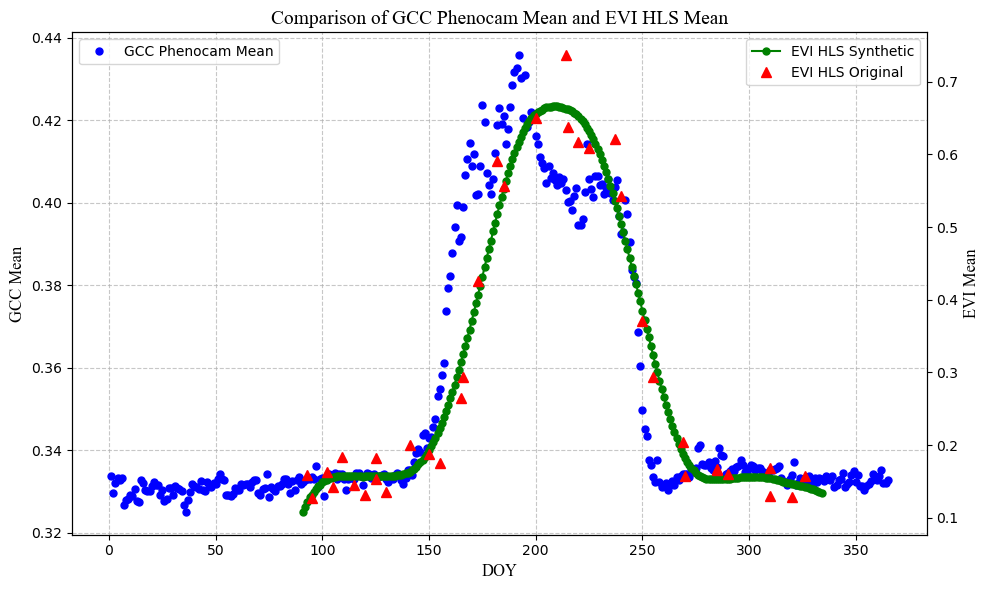

C:\anaconda\envs\hls\lib\site-packages\shapely\geometry\polygon.py:260: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.geometry = None
C:\anaconda\envs\hls\lib\site-packages\shapely\geometry\polygon.py:260: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.geometry = None
C:\anaconda\envs\hls\lib\site-packages\shapely\geometry\polygon.py:260: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.geometry = None
C:\crop_phenology\src\cropphenology\extract_phenology\evi_mask_extractor.py:126: RuntimeWarning: Mean of empty slice
  mean_value = np.nanmean(masked_image)


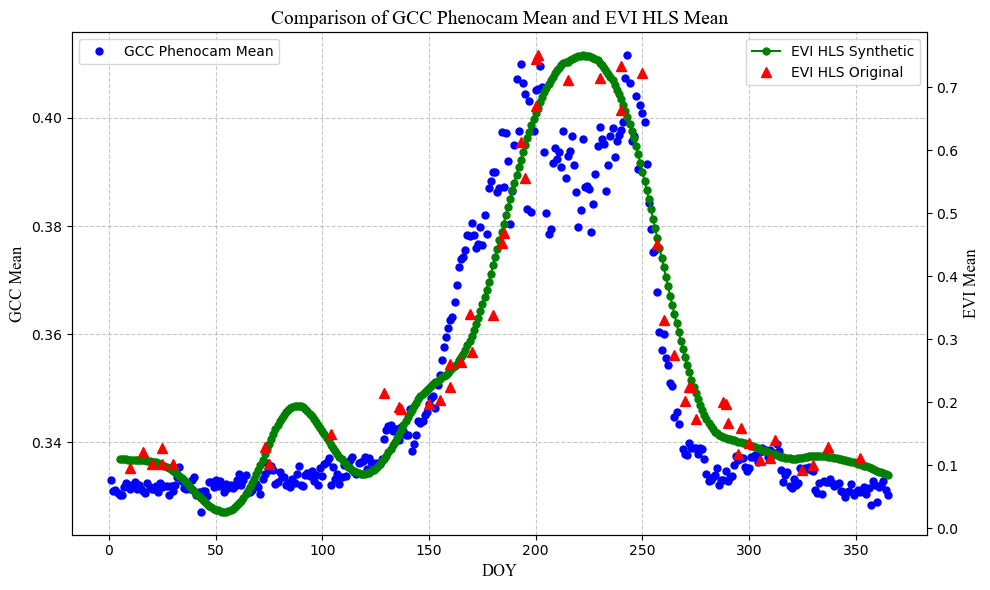

In [28]:

# Define the path to the polygon shapefile representing the field boundary
polygon_path = r'C:\crop_phenology\phenocam_shapefile\field_of_view\field_phenocam_cone_final.shp'
base_dir = r'C:\crop_phenology'
#station_name = 'mandani2'
years = ['2021','2022']

for year in years:
    # Define the path to the Phenocam data for the current year
    phenocam_data = rf'C:\crop_phenology\phenocam_timeseries\{station_name}2_{year}.csv'

    # Process the Phenocam data for the current year
    filtered_phenocam = evi_mask_extractor.processing_phenocam_data(phenocam_data, interval=1)

    # Extract mean EVI values within the polygon shapefile for the current year
    mean_evi_values, dates_doy_mean = evi_mask_extractor.processing_hls_images(base_dir, station_name, polygon_path, year)

    # Extract mean EVI values from the original HLS images for the current year
    original_evi_values, date_doy = evi_mask_extractor.process_hls_original(base_dir, station_name, polygon_path, year)

    # Plot the GCC Phenocam Mean and EVI HLS Mean for the current year
    evi_mask_extractor.plot_phenocam_evi_comparison(filtered_phenocam, mean_evi_values, dates_doy_mean, original_evi_values, date_doy, station_name, base_dir, year)


## 7. Plot the phenological dates using the Zhong et al 2016

In [29]:
# Extract phenological dates from the HLS images predicted
polygon_path = r'C:\crop_phenology\phenocam_shapefile\field_of_view\field_phenocam_cone_final.shp'
base_dir = r'C:\crop_phenology'
#station_name = 'arkansascornsoy'
years = ['2021','2022']

for year in years:
    # Define the path to the Phenocam data for the current year
    phenocam_data = rf'C:\crop_phenology\phenocam_timeseries\{station_name}2_{year}.csv'
    export_excel = rf'C:\crop_phenology\dataframe\{station_name}_{year}_hls.xlsx'
    # Process the Phenocam data
      # Extract mean EVI values from the original HLS images for the current year
    mean_evi_values, dates_doy_mean = evi_mask_extractor.processing_hls_images(base_dir, station_name, polygon_path, year)
    # For simplicity, assuming all dates are from the same year. If multiple years are involved, this will need adjustment.

    # Convert DOY to datetime
    dates_mean = [pd.to_datetime(f'{year}{int(doy):03d}', format='%Y%j') for doy in dates_doy_mean]

    # Create a DataFrame with the extracted data
    data = {
        'date': dates_mean,
        'doy': dates_doy_mean,
        'EVI': mean_evi_values
    }
    df = pd.DataFrame(data)

    # Export combined DataFrame to Excel
    df.to_excel(export_excel, index=False)

C:\anaconda\envs\hls\lib\site-packages\shapely\geometry\polygon.py:260: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.geometry = None
C:\anaconda\envs\hls\lib\site-packages\shapely\geometry\polygon.py:260: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.geometry = None
C:\anaconda\envs\hls\lib\site-packages\shapely\geometry\polygon.py:260: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.geometry = None


In [15]:
# Export original data to Excel

In [30]:
# Define the path to the polygon shapefile representing the field boundary
polygon_path = r'C:\crop_phenology\phenocam_shapefile\field_of_view\field_phenocam_cone_final.shp'
base_dir = r'C:\crop_phenology'
#station_name = 'arsmorris1'
years = ['2021','2022', '2023']

for year in years:
    # Define the path to the Phenocam data for the current year

    export_excel = rf'C:\crop_phenology\original_dataframe\{station_name}_{year}_hls.xlsx'
    # Process the Phenocam data
    # Extract mean EVI values within a polygon shapefile representing the field boundary
    original_evi_values, date_doy = evi_mask_extractor.process_hls_original(base_dir, station_name, polygon_path, year)
    # For simplicity, assuming all dates are from the same year. If multiple years are involved, this will need adjustment.

    # Convert DOY to datetime
    dates_mean = [pd.to_datetime(f'{year}{int(doy):03d}', format='%Y%j') for doy in date_doy]

    # Create a DataFrame with the extracted data
    data = {
        'date': dates_mean,
        'doy': date_doy,
        'EVI': original_evi_values
    }
    df = pd.DataFrame(data)

    # Export combined DataFrame to Excel
    df.to_excel(export_excel, index=False)

C:\anaconda\envs\hls\lib\site-packages\shapely\geometry\polygon.py:260: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.geometry = None
C:\anaconda\envs\hls\lib\site-packages\shapely\geometry\polygon.py:260: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.geometry = None
C:\crop_phenology\src\cropphenology\extract_phenology\evi_mask_extractor.py:126: RuntimeWarning: Mean of empty slice
  mean_value = np.nanmean(masked_image)
C:\anaconda\envs\hls\lib\site-packages\shapely\geometry\polygon.py:260: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.geometry = None
C:\crop_phenology\src\cropphenology\extract_phenology\evi_mask_extractor.py:126: RuntimeWarning: Mean of empty slice
  mean_value = np.nanmean(masked_

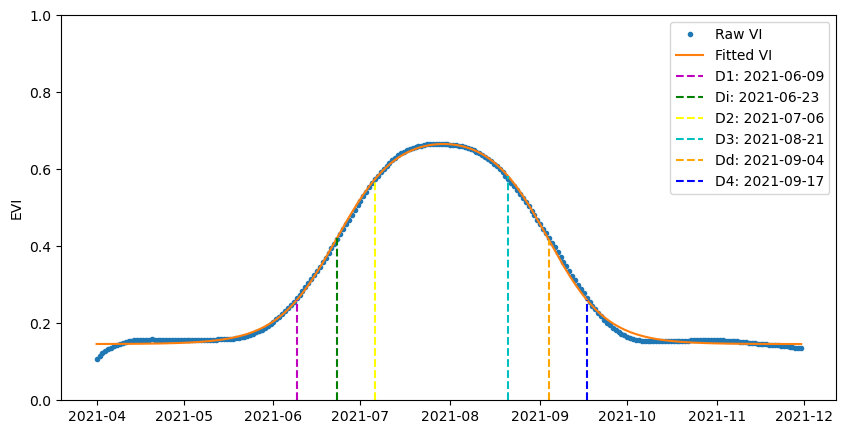

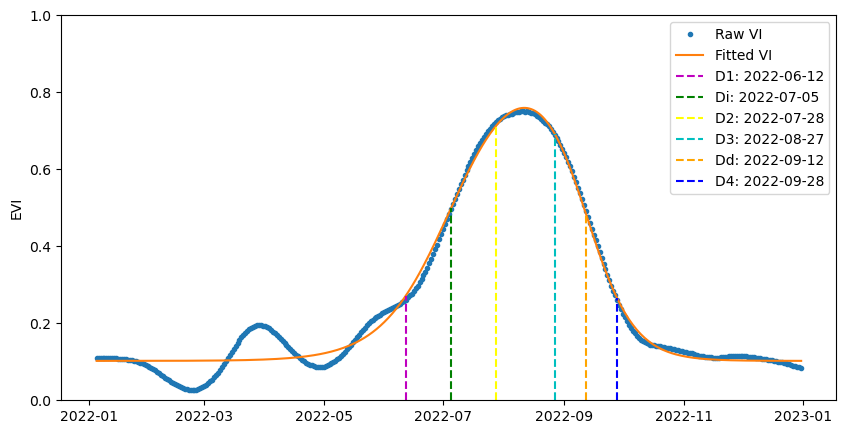

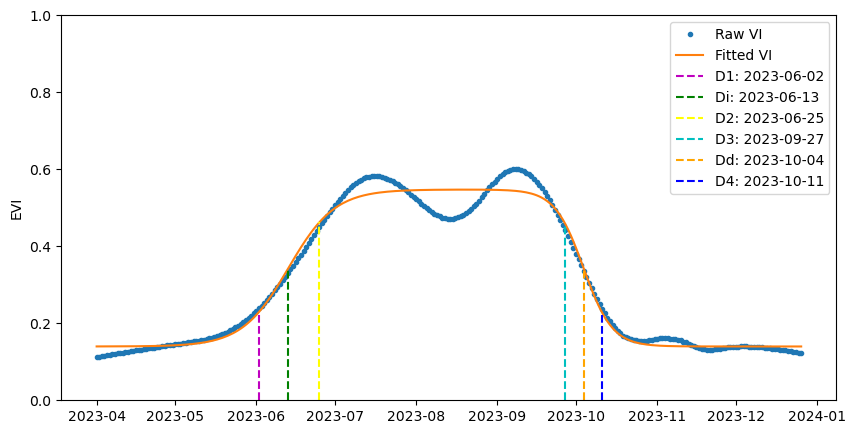

In [31]:
# Read the combined DataFrame
#data_frame = 'arsltarmdcr'
years = ['2021','2022', '2023']
database_name = 'predited_hls'
for year in years:
    df = rf'C:\crop_phenology\dataframe\{station_name}_{year}_hls.xlsx'

    base_dir = r'C:\crop_phenology'

    # Plot the phenological dates
    phenology_dates.extract_phenological_dates(df, base_dir, station_name, year, database_name)

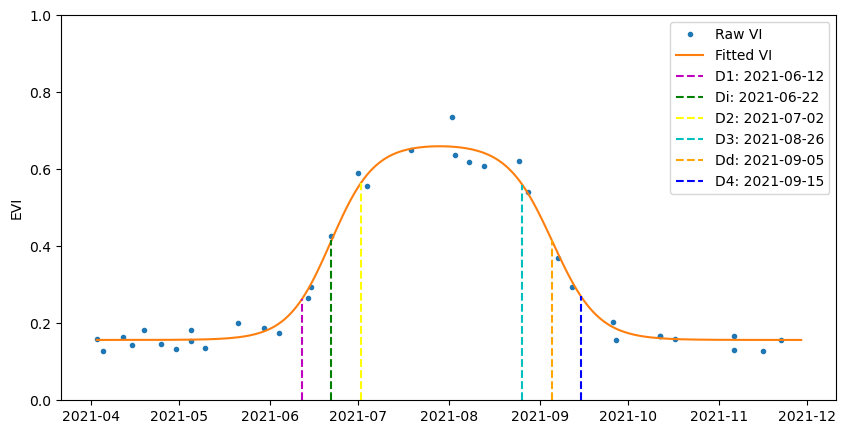

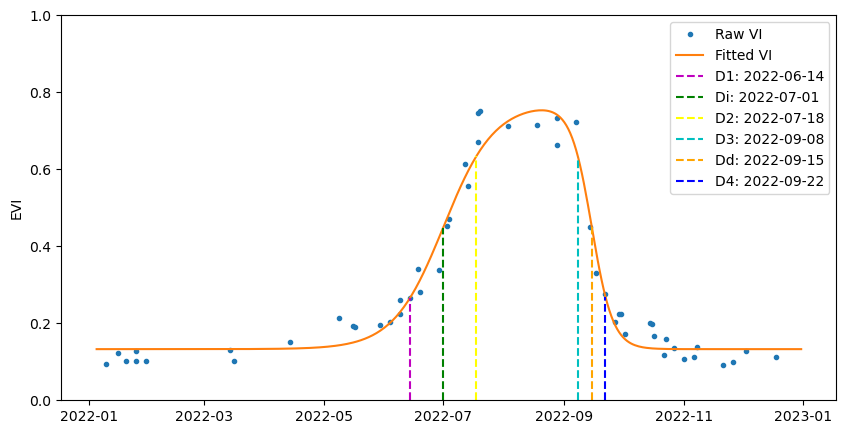

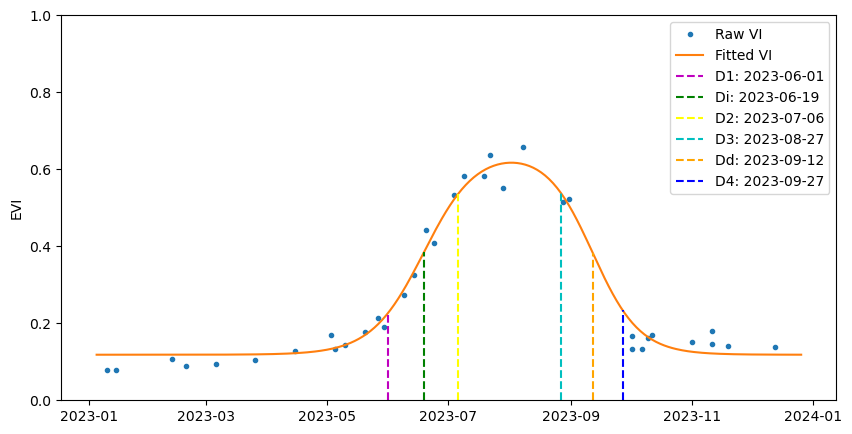

In [32]:
# Extract phenological dates from the original HLS images
#station_name = 'arsope3ltar'
years = ['2021','2022', '2023']
database_name = 'original_hls'
base_dir = r'C:\crop_phenology'

for year in years:
    df = rf'C:\crop_phenology\original_dataframe\{station_name}_{year}_hls.xlsx'
    # Plot the phenological dates
    phenology_dates.extract_phenological_dates(df, base_dir, station_name, year, database_name)

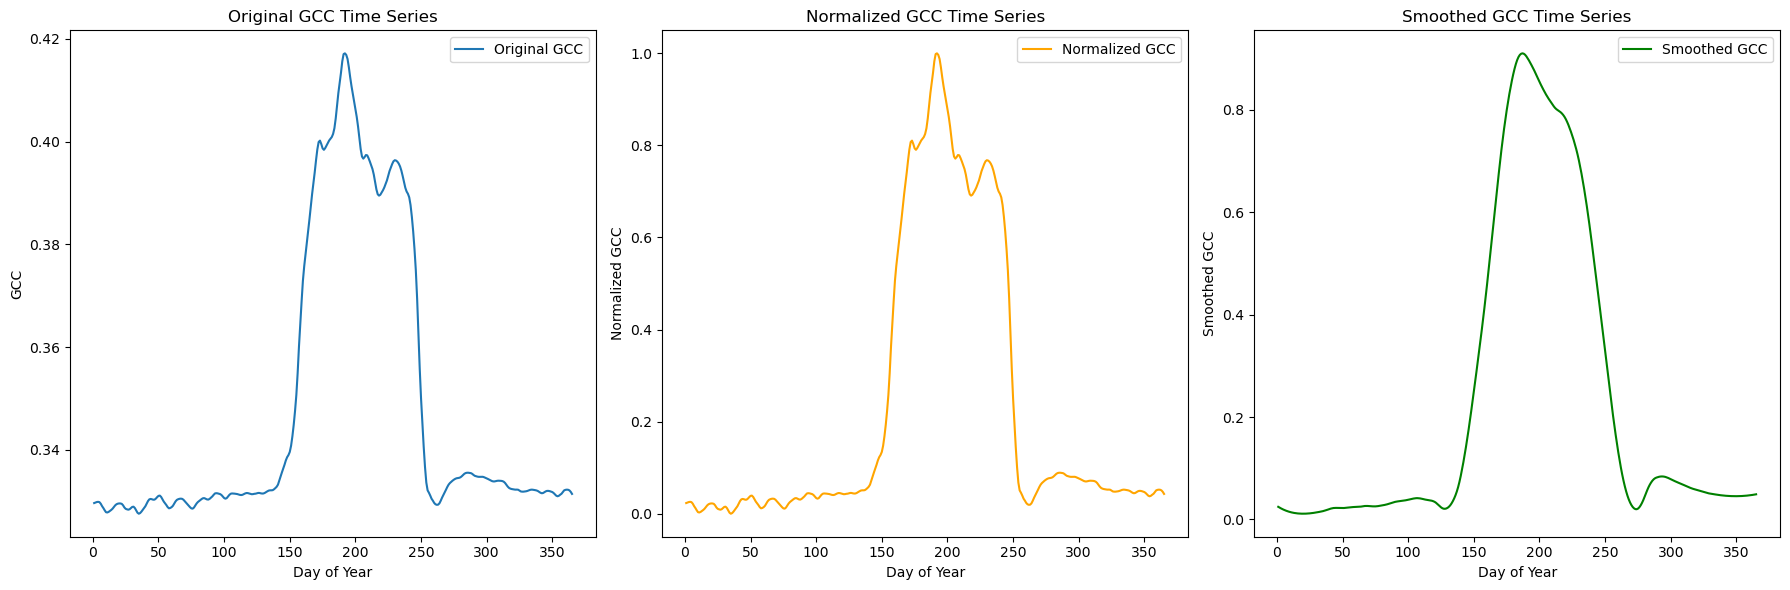

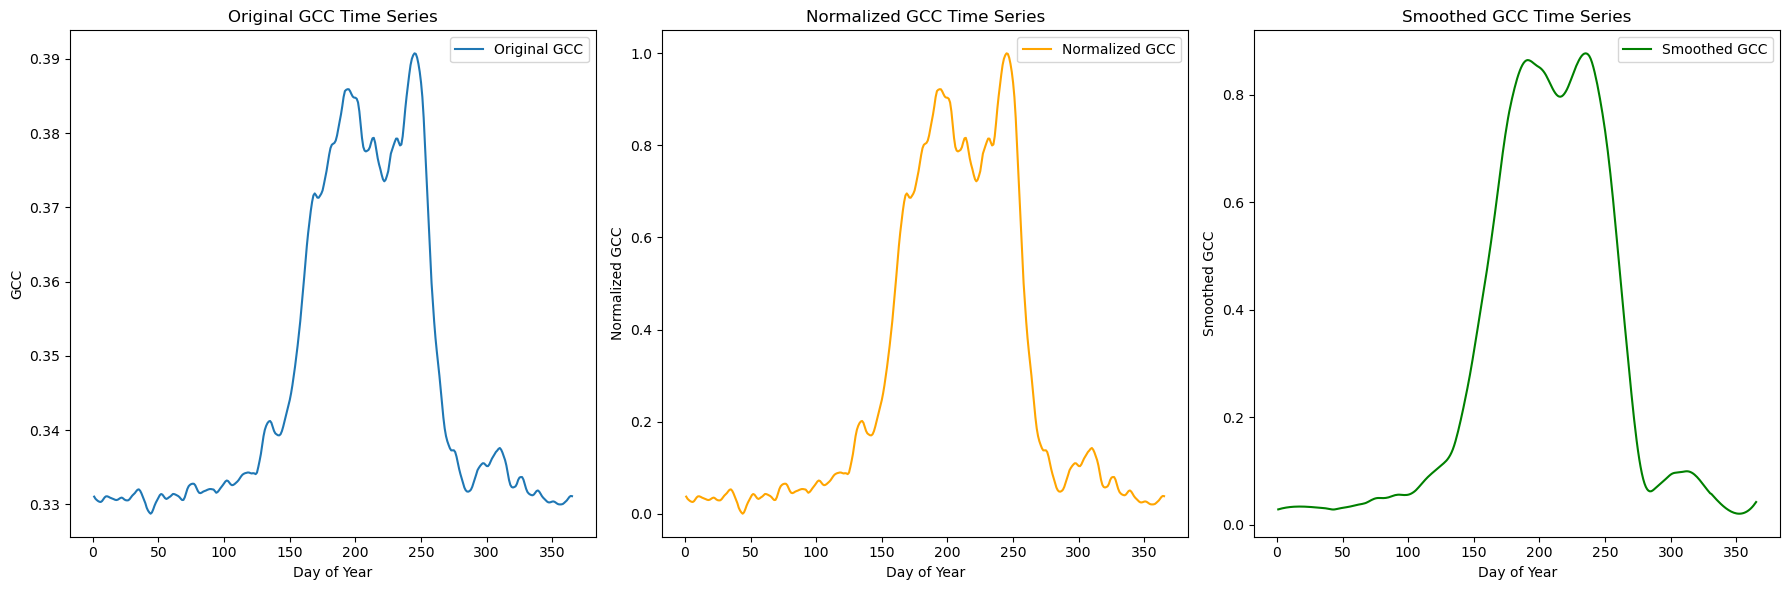

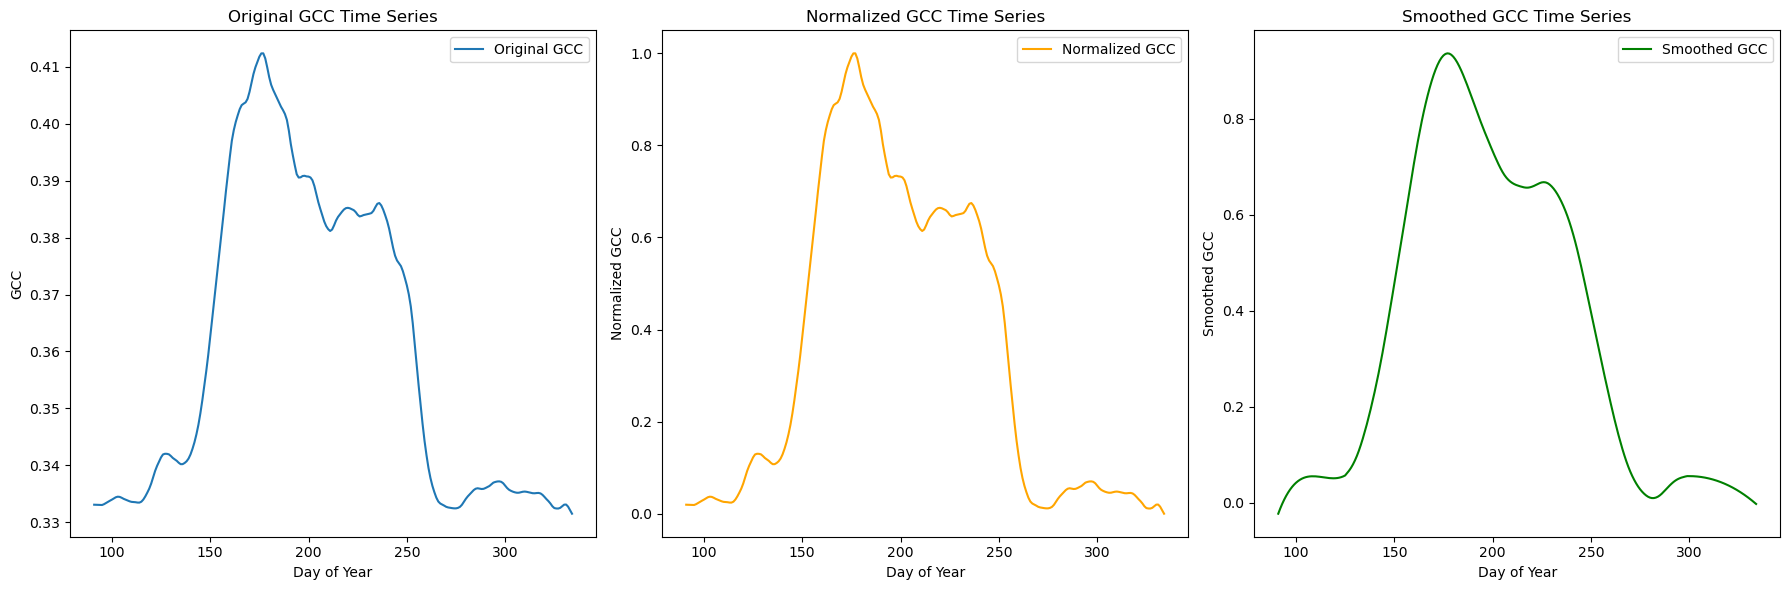

In [34]:
# Normalize the GCC values from phenocam
#station_name = 'uiefmaize2'
base_dir = r'C:\crop_phenology'
years = ['2021','2022','2023']

for year in years:
    # Define the path to the Phenocam data for the current year
    gcc_data = rf'C:\crop_phenology\phenocam_timeseries\{station_name}2_{year}.csv'

    window_length = 70
    poly_order = 3

    normalize_gcc.normalize_gcc(base_dir, station_name, year, gcc_data, window_length, poly_order)


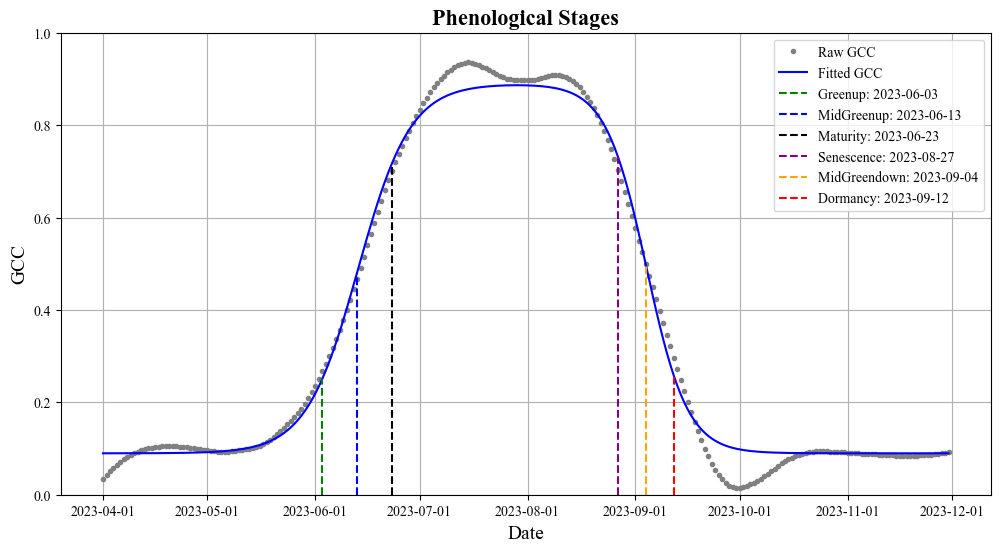

In [2]:
# Extract phenological dates from the normalized GCC values
station_name = 'arsmorris3'
years = ['2023']
base_dir = r'C:\crop_phenology'
database_name = 'phenocam_dates'

for year in years:
    data_frame = f'phenocam_{station_name}'
    df_phenocam = rf'C:\crop_phenology\phenocam_normalized\{station_name}\{station_name}_{year}_normalized_smoothed.xlsx'

    # Plot the phenological dates
    phenology_dates.extract_phenological_dates(df_phenocam, base_dir, data_frame, year, database_name)

## 9. Calibrate the HLS data using the phenocam data


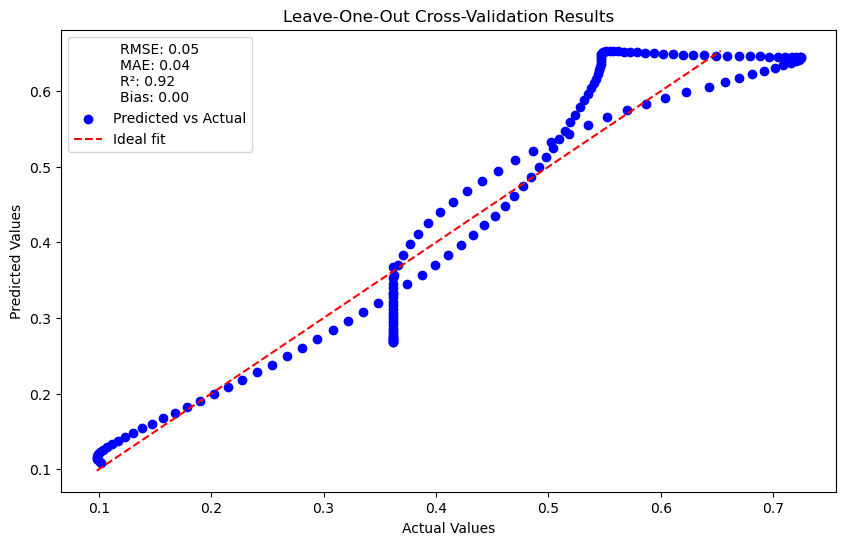

In [57]:
# station_name = 'goodwater'
# years = ['2022']
# base_dir = r'C:\crop_phenology'
#
# for year in years:
#     dataframe_path = rf'C:\crop_phenology\calibration_dataset\{station_name}_{year}.xlsx'
#     calibrate_timeseries.calibrate_hls_timeseries(dataframe_path, station_name, year, base_dir)

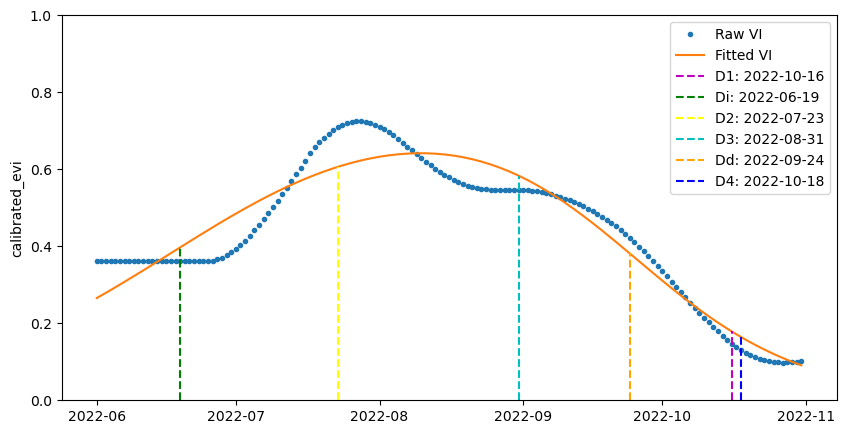

In [58]:
# # Apply the function to extract phenological dates
# station_name = 'goodwater'
# data_frame = f'calibrated_{station_name}'
# years = ['2022']
# base_dir = r'C:\crop_phenology'
#
# for year in years:
#     df_hls = rf'C:\crop_phenology\calibrated_hls\calibrated_values\{station_name}_{year}_hls_calibrated.xlsx'
#
#     calibrate_timeseries.extract_phenological_dates(df_hls, base_dir, data_frame, year)
#



## 9. Create an animation of the Phenocam images and time series of GCC and EVI

C:\anaconda\envs\hls\lib\site-packages\shapely\geometry\polygon.py:260: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.geometry = None
C:\anaconda\envs\hls\lib\site-packages\shapely\geometry\polygon.py:260: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.geometry = None
C:\anaconda\envs\hls\lib\site-packages\shapely\geometry\polygon.py:260: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.geometry = None
C:\crop_phenology\src\cropphenology\extract_phenology\timeplot.py:130: RuntimeWarning: Mean of empty slice
  mean_value = np.nanmean(masked_image)


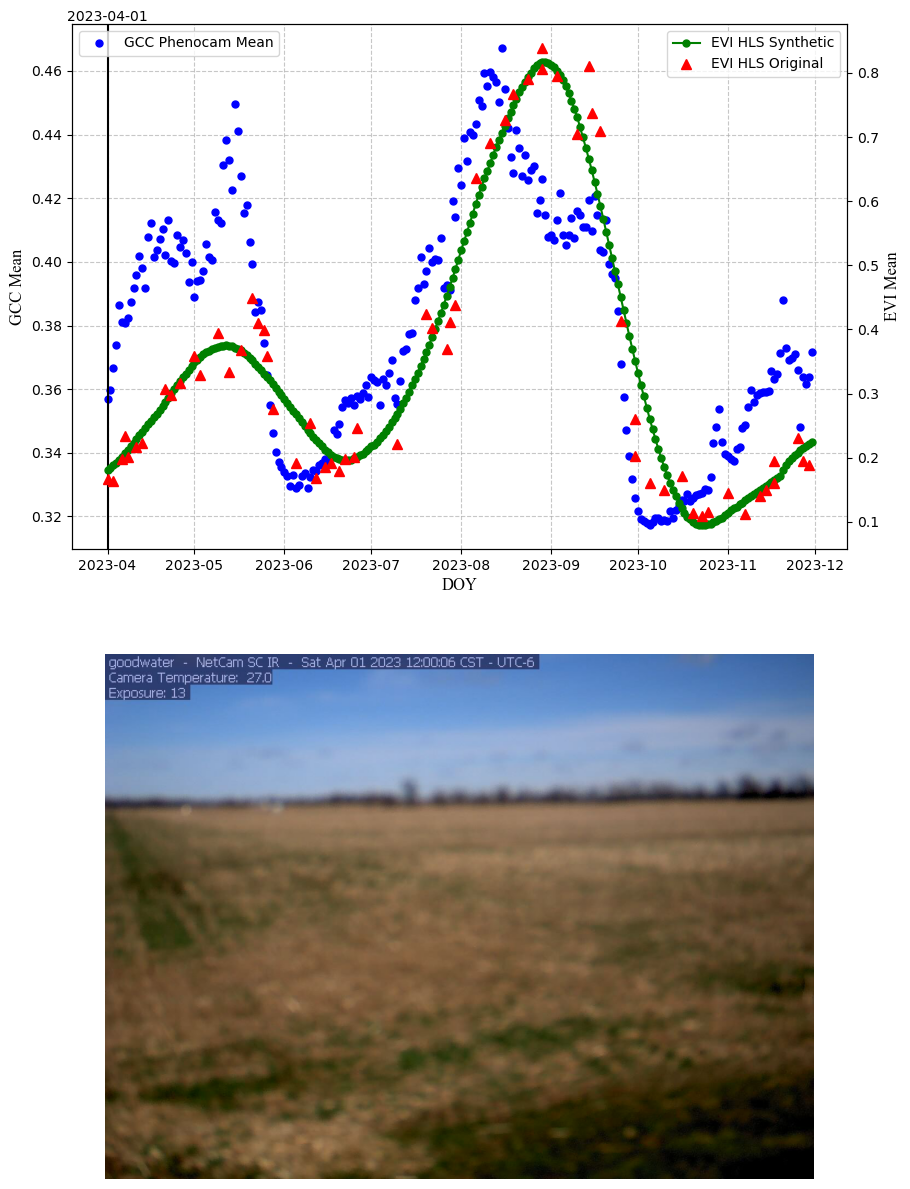

In [86]:

# base dir
base_dir = r'C:\crop_phenology'
station_name = 'goodwater'
# Define the path to the polygon shapefile representing the field boundary
polygon_path = r'C:\crop_phenology\phenocam_shapefile\field_of_view\field_phenocam_cone_final.shp'
phenocam_data = r'C:\crop_phenology\database\goodwater\goodwater_2023.csv'
export_excel = rf'C:\crop_phenology\dataframe\{station_name}_phenocam.xlsx'
# Process the Phenocam data
filtered_phenocam = timeplot.processing_phenocam_data(phenocam_data, interval=1)
# Extract mean EVI values within a polygon shapefile representing the field boundary
mean_evi_values, dates_doy_mean = timeplot.processing_hls_images(base_dir, station_name, polygon_path)
# Extract mean EVI values from the original HLS images
original_evi_values, date_doy = timeplot.process_hls_original(base_dir, station_name, polygon_path)

# Convert the dates from filtered_phenocam['date'] to Day of Year (DOY)
dates_img_phenocam = pd.to_datetime(filtered_phenocam['date'])

# Create a list of image paths
_, image_paths = timeplot.exctrat_phenocam_dates(base_dir, station_name)

# Call the function to create the animation with the timelapse
timeplot.plot_phenocam_evi_comparison_with_animation(filtered_phenocam, mean_evi_values, dates_doy_mean, original_evi_values, date_doy,
                                            station_name, base_dir, dates_img_phenocam, image_paths)
